In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
from sklearn.datasets import fetch_california_housing

data, target = fetch_california_housing(as_frame=True, return_X_y=True
                                       )
target *= 100 #rescale the target in k$
data.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


We know that linear models could be used
even in settings where `data` and `target` are not linearly linked.

We know that one can use the `PolynomialFeatures` transformer to create
additional features encoding non-linear interactions between features.

Here, we will use this transformer to augment the feature space.
Subsequently, we will train a linear regression model. We will use the
out-of-sample test set to evaluate the generalization capabilities of our
model.

In [3]:
from sklearn.model_selection import cross_validate
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression

linear_regression = make_pipeline(PolynomialFeatures(degree=2),
                                  LinearRegression()
)
cv_results = cross_validate(linear_regression, data, target,
                           cv=10, scoring="neg_mean_squared_error",
                           return_train_score = True,
                           return_estimator = True)

In [4]:
# Let us compare the MSE on the training and testing set to assess the generalization performance of the model
train_error = -cv_results["train_score"]
print(f"Mean squared error of linear regression model on the train set:\n"
     f"{train_error.mean():.3f}+/-{train_error.std():.3f}")

Mean squared error of linear regression model on the train set:
4190.212+/-151.123


In [5]:
test_error = -cv_results["test_score"]
print(f"Mean squared error of linear regression model on the train set:\n"
     f"{test_error.mean():.3f}+/-{test_error.std():.3f}")

Mean squared error of linear regression model on the train set:
13334.943+/-20292.681


* The score on the training set is much better. This generalization performance
  gap between the training and testing score is an indication that our model
  overfitted our training set.
  
  
  
  
* Since we used a `PolynomialFeatures` to augment the data, we will create
  feature names representative of the feature combination. Scikit-learn
  provides a `get_feature_names_out` method for this purpose. First, let's get
  the first fitted model from the cross-validation.

In [6]:
model_first_fold = cv_results["estimator"][0]

# Now we can access `PolynomialFeatures` to generate the feature names
feature_names = model_first_fold[0].get_feature_names_out(
    input_features = data.columns
)
feature_names

array(['1', 'MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population',
       'AveOccup', 'Latitude', 'Longitude', 'MedInc^2', 'MedInc HouseAge',
       'MedInc AveRooms', 'MedInc AveBedrms', 'MedInc Population',
       'MedInc AveOccup', 'MedInc Latitude', 'MedInc Longitude',
       'HouseAge^2', 'HouseAge AveRooms', 'HouseAge AveBedrms',
       'HouseAge Population', 'HouseAge AveOccup', 'HouseAge Latitude',
       'HouseAge Longitude', 'AveRooms^2', 'AveRooms AveBedrms',
       'AveRooms Population', 'AveRooms AveOccup', 'AveRooms Latitude',
       'AveRooms Longitude', 'AveBedrms^2', 'AveBedrms Population',
       'AveBedrms AveOccup', 'AveBedrms Latitude', 'AveBedrms Longitude',
       'Population^2', 'Population AveOccup', 'Population Latitude',
       'Population Longitude', 'AveOccup^2', 'AveOccup Latitude',
       'AveOccup Longitude', 'Latitude^2', 'Latitude Longitude',
       'Longitude^2'], dtype=object)

In [7]:
# Let us now a df using the features obtained
import pandas as pd
coefs = [est[-1].coef_ for est in cv_results["estimator"]]
weights_linear_regression = pd.DataFrame(coefs, columns = feature_names)

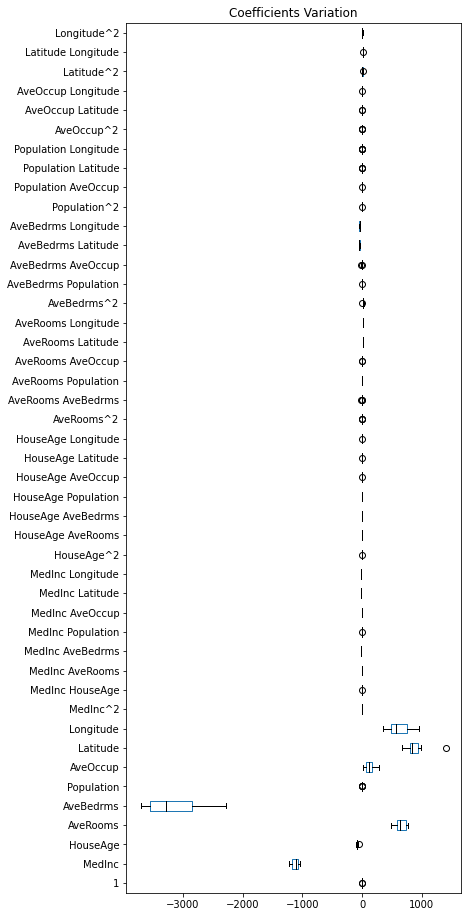

In [8]:
# A boxplot to visualize the coefficients variation
import matplotlib.pyplot as plt

color = {"whiskers":"black","medians":"black","caps":"black"}
weights_linear_regression.plot.box(color=color, vert=False, figsize=(6,16))
_ = plt.title("Coefficients Variation")

* We can force the linear regression model to consider all features in a more
  homogeneous manner. In fact, we could force large positive or negative weight
  to shrink toward zero. This is known as regularization. We will use a ridge
   model which enforces such behavior.

In [9]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import Ridge
ridge = make_pipeline(PolynomialFeatures(degree=2), Ridge(alpha=100))
cv_results = cross_validate(ridge, data, target, cv=10, scoring = "neg_mean_squared_error", 
                            return_train_score = True,
                           return_estimator = True)

* The code cell above will generate a couple of warnings because the features
  included both extremely large and extremely small values, which are causing
   numerical problems when training the predictive model. You might want to suppress it using the `warnings` library


In [10]:
# Let us explore the test and train scores of the model
train_error = -cv_results["train_score"]
print(f"Mean squared of linear regression model on the train set:\n"
     f"{train_error.mean():.2f} +/- {train_error.std():.2f}")

print("\n")

test_error = -cv_results["test_score"]
print(f"Mean squared of linear regression model on the test set:\n"
     f"{test_error.mean():.2f} +/- {test_error.std():.2f}")

Mean squared of linear regression model on the train set:
4373.18 +/- 153.94


Mean squared of linear regression model on the test set:
7303.59 +/- 4950.73


* We see that the training and testing scores are much closer, indicating that
  our model is less overfitting. We can compare the values of the weights of
   ridge with the un-regularized linear regression.

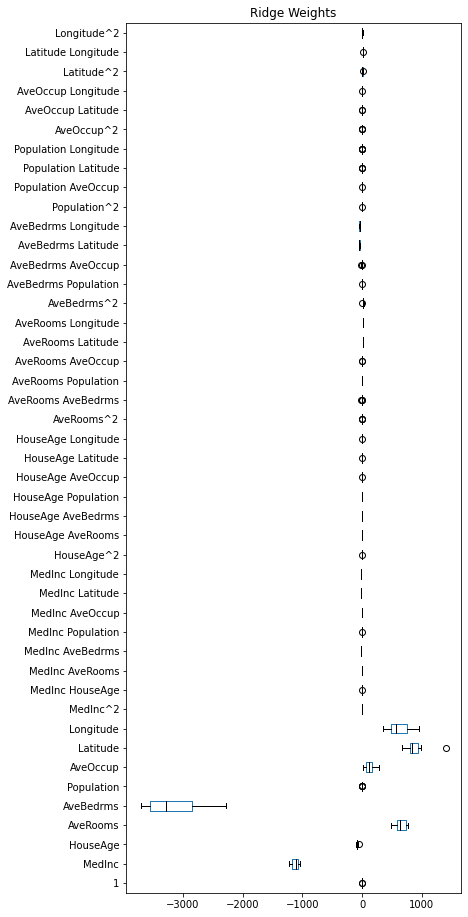

In [11]:
coefs = [est[-1].coef_ for est in cv_results["estimator"]]
weights_ridge = pd.DataFrame(coefs, columns = feature_names)

weights_linear_regression.plot.box(color=color, vert=False, figsize=(6,16))
_ = plt.title("Ridge Weights")

* We recall that regularization forces weights to be closer. Therefore, we get
  an intuition that if we want to use regularization, dealing with rescaled
  data would make it easier to find an optimal regularization parameter and
  thus an adequate model.

* As a side note, some solvers based on gradient computation are expecting such
  rescaled data. Unscaled data will be detrimental when computing the optimal
  weights. Therefore, when working with a linear model and numerical data, it
  is generally good practice to scale the data.

* Thus, we will add a `StandardScaler` in the machine learning pipeline. This
  scaler will be placed just before the regressor.

In [12]:
from sklearn.preprocessing import StandardScaler

ridge = make_pipeline(PolynomialFeatures(degree=2),
                     StandardScaler(),
                     Ridge(alpha=.5))
cv_results = cross_validate(ridge, data, target, cv=10, scoring="neg_mean_squared_error",
                           return_train_score = True, return_estimator = True)

In [13]:
# Let us obtain the train and test scores
train_error = -cv_results["train_score"]
print(f"The train error is {train_error.mean():.3f} +/- {train_error.std():.3f}")

The train error is 4347.036 +/- 156.666


In [14]:
test_error = -cv_results["test_score"]
print(f"The train error is {test_error.mean():.3f} +/- {test_error.std():.3f}")

The train error is 5508.472 +/- 1816.642


We observe that scaling data has a positive impact on the test score and that
the test score is closer to the train score. It means that our model is less
overfitted and that we are getting closer to the best generalization sweet
spot.

Let's have an additional look to the different weights.

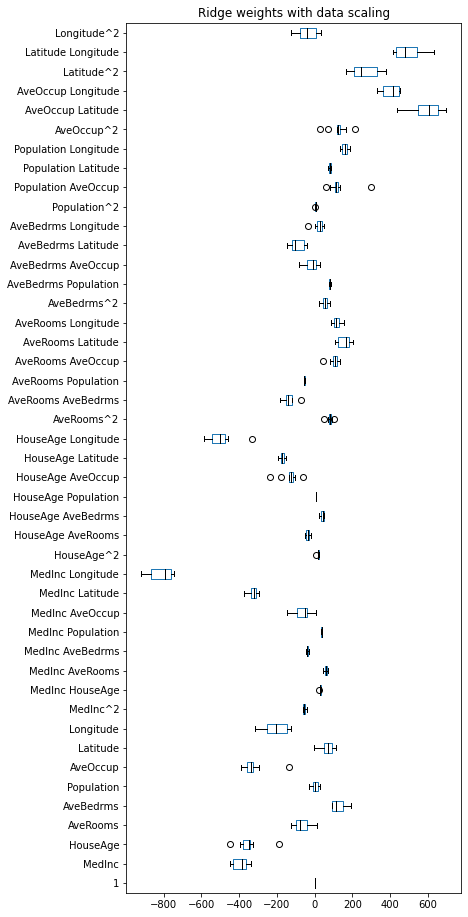

In [15]:
coefs = [est[-1].coef_ for est in cv_results["estimator"]]
weights_ridge = pd.DataFrame(coefs, columns=feature_names)

weights_ridge.plot.box(color=color, vert=False, figsize=(6, 16))
_ = plt.title("Ridge weights with data scaling")

Compare to the previous plots, we see that now all weight magnitudes are
closer and that all features are more equally contributing.

In the previous example, we fixed `alpha=0.5`. We will now check the impact
of the value of `alpha` by increasing its value.

In [16]:
ridge = make_pipeline(PolynomialFeatures(degree=2), StandardScaler(),
                      Ridge(alpha=1_000_000))
cv_results = cross_validate(ridge, data, target,
                            cv=10, scoring="neg_mean_squared_error",
                            return_train_score=True,
                            return_estimator=True)

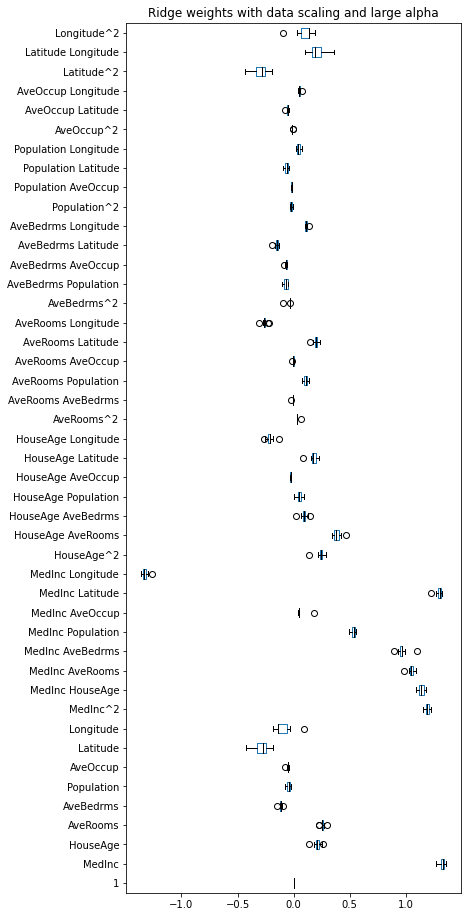

In [17]:
coefs = [est[-1].coef_ for est in cv_results["estimator"]]
weights_ridge = pd.DataFrame(coefs, columns=feature_names)

weights_ridge.plot.box(color=color, vert=False, figsize=(6, 16))
_ = plt.title("Ridge weights with data scaling and large alpha")

Looking specifically to weights values, we observe that increasing the value
of `alpha` will decrease the weight values. A negative value of `alpha` would
actually enhance large weights and promote overfitting.


## Fine tuning the regularization parameter

In [18]:
import numpy as np
from sklearn.linear_model import RidgeCV

alphas = np.logspace(-2, 0, num=20)
ridge = make_pipeline(PolynomialFeatures(degree=2), StandardScaler(),
                      RidgeCV(alphas=alphas, store_cv_values=True))

In [19]:
from sklearn.model_selection import ShuffleSplit

cv = ShuffleSplit(n_splits=5, random_state=1)
cv_results = cross_validate(ridge, data, target,
                            cv=cv, scoring="neg_mean_squared_error",
                            return_train_score=True,
                            return_estimator=True, n_jobs=2)

In [20]:
train_error = -cv_results["train_score"]
print(f"Mean squared error of linear regression model on the train set:\n"
      f"{train_error.mean():.3f} +/- {train_error.std():.3f}")

test_error = -cv_results["test_score"]
print(f"Mean squared error of linear regression model on the test set:\n"
      f"{test_error.mean():.3f} +/- {test_error.std():.3f}")

Mean squared error of linear regression model on the train set:
4306.562 +/- 25.918
Mean squared error of linear regression model on the test set:
4348.657 +/- 252.921


In [21]:
mse_alphas = [est[-1].cv_values_.mean(axis=0)
              for est in cv_results["estimator"]]
cv_alphas = pd.DataFrame(mse_alphas, columns=alphas)
cv_alphas

,0.010000,0.012743,0.016238,0.020691,0.026367,0.033598,0.042813,0.054556,0.069519,0.088587,0.112884,0.143845,0.183298,0.233572,0.297635,0.379269,0.483293,0.615848,0.784760,1.000000
0,7587.897141,7059.531216,6579.796667,6161.839629,5813.048345,5535.350138,5326.646369,5182.950517,5100.749049,5079.212663,5122.029454,5238.704149,5445.118890,5763.012259,6217.925433,6835.274126,7634.692137,8623.620241,9791.918443,11109.476019
1,7079.341771,6696.622046,6329.022308,5987.727181,5681.306000,5415.171818,5191.880969,5012.209177,4876.780585,4787.974274,4751.851652,4779.853646,4889.937328,5106.656625,5459.549144,5979.280717,6691.530974,7609.581815,8727.609953,10017.092899
2,24857.406605,21448.284772,18293.478416,15481.009011,13067.031991,11071.457116,9480.437579,8254.431555,7338.963939,6675.026438,6207.024331,5887.541169,5679.263698,5554.913823,5496.051755,5491.367683,5534.775517,5623.398006,5755.456140,5928.154410
3,7504.216958,7125.074257,6754.172985,6400.999897,6072.937966,5774.941819,5509.955509,5280.027720,5087.960263,4939.271829,4844.228092,4819.618117,4889.808854,5086.420585,5445.877349,6004.320850,6790.113763,7815.311733,9068.542918,10511.939341
4,6999.938808,6598.898742,6215.363499,5861.328579,5546.025773,5275.377052,5052.349007,4878.140850,4753.964890,4683.117084,4673.049960,4737.162496,4895.935124,5176.863333,5612.500529,6236.037942,7074.449338,8140.303978,9424.471281,10892.352852


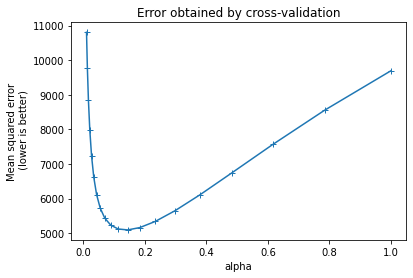

In [22]:
cv_alphas.mean(axis=0).plot(marker="+")
plt.ylabel("Mean squared error\n (lower is better)")
plt.xlabel("alpha")
_ = plt.title("Error obtained by cross-validation")

In [23]:
best_alphas = [est[-1].alpha_ for est in cv_results["estimator"]]
best_alphas

[0.08858667904100823,
 0.11288378916846889,
 0.37926901907322497,
 0.14384498882876628,
 0.11288378916846889]

In [24]:
print(f"The mean optimal alpha leading to the best generalization performance is:\n"
      f"{np.mean(best_alphas):.2f} +/- {np.std(best_alphas):.2f}")

The mean optimal alpha leading to the best generalization performance is:
0.17 +/- 0.11
